In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import leastsq,curve_fit

np.set_printoptions(threshold=np.inf)

In [2]:
#悬链线方程，需要拟合a,b,c三个参数
def function(x, a, b, c):
    result = a * np.cosh((x-b)/a) + c
    return result

In [3]:
#读取原图片
def load_image(file_path,file_name,file_ext):
    file = file_path + file_name + file_ext;
    Image = plt.imread(file);
    
    [image_y_max,image_x_max] = Image.shape;
    print(f"原图片高度：{image_y_max},原图片宽度：{image_x_max}");
    plt.imshow(Image,cmap = "gray");
    plt.show()
    return Image;

In [4]:
#裁剪原图片
def extract_edge(Image,file_path,file_name):
    [image_y_max,image_x_max] = Image.shape;
    min_x = max_x = min_y = max_y = 0;
    sum_col = np.sum(Image,axis=0);
    for i in range(0,image_x_max):
        if (sum_col[i] != 0):
            min_x = i;
            break;
    for i in range(image_x_max-1,min_x,-1):
        if (sum_col[i] != 0):
            max_x = i;
            break;


    sum_row = np.sum(Image,axis=1);
    for i in range(0,image_y_max):   
        if (sum_row[i] != 0):
            min_y = i;
            break; 
    for i in range(image_y_max - 1,min_y,-1):
        if (sum_row[i] != 0):
            max_y = i;
            break;

    Image = Image[min_y:max_y,min_x:max_x];

    [image_y_max, image_x_max] =  Image.shape;
    print('裁剪后高度:%d,裁剪后宽度:%d\n' %(image_y_max,image_x_max));
    
    ## 发现像素矩阵的值不是0/1，把非零值改为1。
    for i in range(0,image_x_max):
        for j in range(0,image_y_max):
            if (Image[j,i] != 0):
                Image[j,i] = 1;
                
    #print("裁剪且提取边缘后的矩阵：\n");
    #print(Image);          
                
    Image_refine = np.zeros((image_y_max,image_x_max));
    for x in range(0,image_x_max): 
        is_white = False;
        for y in range(image_y_max-1,-1,-1):
            v = x;
            u = int(-y + image_y_max - 1);
            if (Image[u,v] != 0):
                if (is_white == False):
                    Image_refine[u,v] = 1;
                    is_white = True;
               #else:
               #    Image[u,v] = 0;
            else:
                is_white = False;
                
    # for x in range(0,image_x_max): 
    #     start = end  = 0;
    #     for y in range(image_y_max-1,-1,-1):
    #         v = x;
    #         u = int(-y + image_y_max - 1);
    #         if (Image[u,v] != 0):
    #             if (u == 0) or (Image[u-1,v] == 0):#开始
    #                 start = u;
    #             if (u == image_y_max-1) or (Image[u+1,v] == 0):#结束 
    #                 end = u;
    #             if(end != 0): # 遍历完一段曲线，求中，把start、end复原
    #                 mid = int((start+end)/2);
    #                 Image_refine[mid,v] = 1;
    #                 start = end  = 0;
                    
                    
    plt.xlim((0, image_x_max));
    plt.ylim((image_y_max, 0));
    plt.imshow(Image_refine,cmap = "gray");
    file = file_path + "cut\\" + file_name + "_cut.png";
    plt.savefig(file);
    plt.show();
    return Image_refine;

In [5]:
#判断有几条曲线，选择能够提供充分样点的最大曲线数。
def get_curve_number(Image):
    [image_y_max,image_x_max] = Image.shape;
    count = np.sum(Image,axis = 0);
    #print("像素矩阵每一行的和: ");
    #print(count);
    num_curve = int(np.max(count));
    num_curve_part = np.where(count==num_curve);
    length = np.size(num_curve_part);

    min_length = round(image_x_max/20);

    while (length < min_length):
        count[num_curve_part] = 0;
        num_curve = int(np.max(count));
        num_curve_part= np.where(count==num_curve);
        length = np.size(num_curve_part);

    print("判定缆绳数量为：%d" %(num_curve));  
       
    return [num_curve,count];

In [6]:
##根据像素矩阵的列和判断是否有交点，我们希望截取一段无交点部分(最长的部分)
def get_sample_points(Image):
    [num_curve,count] = get_curve_number(Image);
    [image_y_max,image_x_max] = Image.shape;
    length = 0;
    start = end = 0;
    share_index = 0;
    while (start < image_x_max) and (end < image_x_max):
        while (start < image_x_max ) and (count[start] != num_curve):
            start = start + 1;
        end = start + 1;
        while (end < image_x_max) and (count[end] == num_curve):
            end = end + 1;
        sublength = end - start;
        if (sublength > length):
            length = sublength;
            share_index = start;
        start = end + 1;
    print('截取起点：%d, 截取长度：%d\n' %(share_index,length));
    Image_cut  = Image[ : ,share_index : share_index + length - 1];
    [imagecut_y_max,imagecut_x_max] = Image_cut.shape;
    plt.imshow(Image_cut,cmap = "gray");
    plt.show()

    sample_points = np.zeros((imagecut_x_max,2,num_curve));
    for i in range(0,imagecut_x_max):
        curve_id = 0;
        for j in range(imagecut_y_max-1,-1,-1):
            x = i + share_index;
            y = -j + imagecut_y_max - 1;
            if (Image_cut[y,i] != 0):
                sample_points[i,0,curve_id] = x;
                sample_points[i,1,curve_id] = j;
                curve_id  = curve_id + 1;
    return [Image_cut,sample_points];

In [7]:
#开始第一次拟合
def initial_fit(Image,sample_points):
    [image_y_max,image_x_max] = Image.shape;
    num_curve = int(sample_points.shape[2]);
    parameter_origin = np.zeros((num_curve,3));
    for i in range(0,num_curve):
        y = sample_points[:,1,i];
        x = sample_points[:,0,i];
        parameter_initial = [image_y_max,image_x_max,-image_y_max];
        #[parameter, _] = leastsq(f_err, parameter_initial, args=(y, x));
        parameter,pcov = curve_fit(function,x,y,p0 = parameter_initial,method = 'dogbox',max_nfev=100000);
        parameter_origin[i,:] = parameter;
                                        
    plt.xlim((0, image_x_max))
    plt.ylim((image_y_max, 0))
    plt.imshow(Image,cmap = "gray");
    for id  in range(0,num_curve):
        t = parameter_origin[id,:];
        x_fit = np.zeros(image_x_max);
        y_fit = np.zeros(image_x_max);
        
        for x in range(0,image_x_max):
            x_fit[x] = x;
            y_fit[x] = t[0]*np.cosh((x - t[1])/ t[0]) + t[2];
            
        u_fit = - y_fit + image_y_max;
        plt.plot(x_fit,u_fit,color = 'green',linewidth = 2);
    plt.show()
    return parameter_origin;

In [8]:
#迭代扩展样本点，进行拟合
def iterate_fit(Image,sample_points_origin,parameter_origin,iterate_time):
    [image_y_max,image_x_max] = Image.shape;
    num_curve = int(sample_points_origin.shape[2]);

    parameter_old = parameter_origin;
    sample_points_old = sample_points_origin;

    expansion_size = int(round(image_x_max/(iterate_time)));

    for time in range(0,iterate_time):        

        pnt_num = sample_points_old.shape[0];
        x_cut_min = sample_points_old[0,0,0];
        x_cut_max = sample_points_old[pnt_num-1,0,0];
        if (x_cut_min > expansion_size):
            x_cut_min = x_cut_min - expansion_size;
        else:
            x_cut_min = 0;

        if ( image_x_max - x_cut_max > expansion_size):
            x_cut_max = x_cut_max + expansion_size;
        else:
            x_cut_max = image_x_max - 1;

        x_cut_size = int(x_cut_max - x_cut_min + 1);
        sample_points_new = np.zeros((x_cut_size,2,num_curve));
        for i in range(0,num_curve):
            for x in range(0,x_cut_size):
                sample_points_new[x,0,i] = x + x_cut_min; 

        for  x  in range(0,x_cut_size):
            for y in range(image_y_max-1,-1,-1):
                u = int(-y + image_y_max - 1);
                v = int(x + x_cut_min);
                if (Image[u,v] != 0):
                    y_distance = np.zeros(num_curve);
                    for id in range(0,num_curve):
                        t = parameter_old[id,:];
                        y_fit = t[0]*np.cosh((v - t[1])/ t[0]) + t[2];
                        y_distance[id] = np.abs(y_fit - y);

                    #寻找离这个点最近的曲线，距离小于12的点，均视为该曲线的样本点
                    min_distance = np.min(y_distance);
                    if (min_distance < 12):
                        curve_id = np.where(y_distance == min_distance);
                        sample_points_new[x,1,curve_id] = y;
                    # while (min_distance <= 12):
                    #     curve_id = np.where(y_distance == min_distance);
                    #     y_old = sample_points_new[x,1,curve_id];
                    #     if (y_old != 0):
                    #         old_distance = np.abs(y_old - y);
                    #         if (old_distance > min_distance ):
                    #             sample_points_new[x,1,curve_id] = y;
                    #     else:
                    #         sample_points_new[x,1,curve_id] = y;
                    #     y_distance[curve_id] = 100;
                    #     min_distance = np.min(y_distance);

        parameter_new = np.zeros((num_curve,3));
        for id in range(0, num_curve):
            sample_x = sample_points_new[:,0,id];
            sample_y = sample_points_new[:,1,id];
            #将曲线中没有选定点的列删除。
            zero_column = np.where(sample_y == 0);
            sample_x = np.delete(sample_x,zero_column);
            sample_y = np.delete(sample_y,zero_column);


            parameter_initial = parameter_old[id,:]; 
            #[parameter, _] = leastsq(f_err, parameter_initial, args=(sample_y, sample_x));      
            parameter,pcov = curve_fit(function,sample_x,sample_y,p0 = parameter_initial,method = 'dogbox',max_nfev=100000);
            parameter_new[id,:] = parameter;             

        print("Iterate_time:%d \n" %(time));
        for id in range(0,num_curve):
            a = parameter_new[id,0];
            b = parameter_new[id,1];
            c = parameter_new[id,2];
            print("y = %f*cosh((x- %f)/%f) + %f \n" %(a,b,a,c))   
        parameter_old = parameter_new;
        sample_points_old = sample_points_new;
    return [parameter_old,sample_points_old];

In [9]:
#计算弯曲度
def calculate_radian(parameter,sample_points,file_path,file_name):
    num_curve = int(sample_points.shape[2]);
    radian = np.zeros(num_curve);
    for id in range(0,num_curve):
        sample_x = sample_points[:,0,id];
        sample_y = sample_points[:,1,id];
        #将曲线中没有选定点的列删除。
        zero_column = np.where(sample_y == 0);
        sample_x = np.delete(sample_x,zero_column);
        sample_y = np.delete(sample_y,zero_column);
                
        #取出样本点的起点和终点，画出直线。
        pnt_num = sample_x.shape[0];
        x_start = sample_x[0];
        y_start = sample_y[0];
        x_end = sample_x[pnt_num-1];
        y_end = sample_y[pnt_num-1];
                
        #起点到终点的直线。
        k = (y_end - y_start) / (x_end - x_start);
        b = y_end - k * x_end;
                

                
        #计算曲线到直线的距离，取出最大值计算弯曲度
        line_length  = np.sqrt(pow(x_end - x_start,2) + pow(y_end - y_start,2));
        distance = np.zeros(pnt_num);
        for i in range(0,pnt_num):
            distance[i] = np.abs(k*sample_x[i] - sample_y[i] + b) / np.sqrt(1 + k*k);

        max_distance = np.max(distance);
        radian[id] = max_distance / line_length;
        print("y = %f x + %f \n" %(k,b));
    print(radian)
    file = file_path + "parameter\\" + file_name +"_parameter.txt";
    f = open(file, 'w',encoding='UTF-8');
    f.write("%12s %12s %12s\n" %("a","b","c"));
    for i in range(0,num_curve):
        f.write(str(parameter[i,:])+'\n')
    f.write("radian : "+ str(radian));
    f.close();

    return radian

In [10]:
#保存拟合结果图片
def save_png(Image,parameter,file_path,file_name):
    [image_y_max,image_x_max] = Image.shape;
    num_curve = int(parameter.shape[0]);
    plt.xlim((0, image_x_max));
    plt.ylim((image_y_max, 0));
    plt.imshow(Image,cmap = "gray");
    for id  in  range(0,num_curve):
        t = parameter[id,:];
        x_fit = np.zeros(image_x_max);
        y_fit = np.zeros(image_x_max);
        for x in range(0,image_x_max):
            x_fit[x] = x;
            y_fit[x] = t[0]*np.cosh((x - t[1])/ t[0]) + t[2];
        u_fit = - y_fit + image_y_max - 1;
        plt.plot(x_fit,u_fit,color = 'green',linewidth = 2);
    file = file_path + "fit\\" + file_name + "_fit.png";
    plt.savefig(file);
    plt.show()

In [11]:
#整合拟合过程
def catenary_fit(file_path,file_name,file_ext,iterate_time):
    Image = load_image(file_path,file_name,file_ext);
    Image = extract_edge(Image,file_path,file_name);
    [Image_cut,sample_points_origin] = get_sample_points(Image);
    parameter_origin = initial_fit(Image,sample_points_origin);
    [parameter,sample_points] = iterate_fit(Image,sample_points_origin,parameter_origin,iterate_time);
    radian = calculate_radian(parameter,sample_points,file_path,file_name);
    save_png(Image,parameter,file_path,file_name);


.\figure\20.png

迭代次数: 6
原图片高度：798,原图片宽度：1280


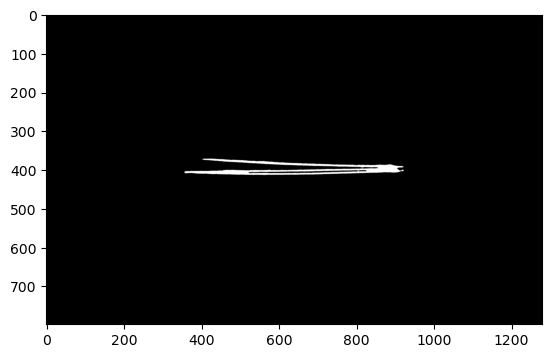

裁剪后高度:43,裁剪后宽度:567



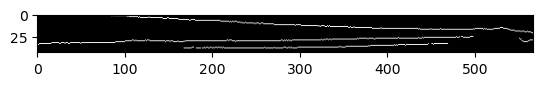

判定缆绳数量为：3
截取起点：189, 截取长度：259



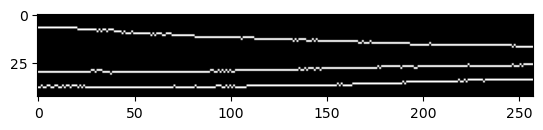

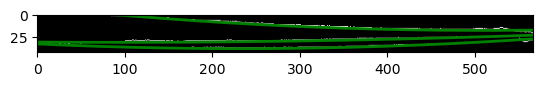

Iterate_time:0 

y = 6002.539018*cosh((x- 528.278444)/6002.539018) + -5977.411083 

y = 13680.168450*cosh((x- 118.880025)/13680.168450) + -13668.406253 

y = 5702.238132*cosh((x- 220.925679)/5702.238132) + -5698.134597 

Iterate_time:1 

y = 8237.498723*cosh((x- 604.015752)/8237.498723) + -8213.385414 

y = 19775.594200*cosh((x- -18.367293)/19775.594200) + -19765.084469 

y = 5854.452070*cosh((x- 235.082676)/5854.452070) + -5850.107507 

Iterate_time:2 

y = 8631.110771*cosh((x- 620.824104)/8631.110771) + -8607.312386 

y = 30273.296688*cosh((x- -150.345302)/30273.296688) + -30263.480553 

y = 5962.628279*cosh((x- 232.566147)/5962.628279) + -5958.297673 

Iterate_time:3 

y = 8631.110813*cosh((x- 620.824106)/8631.110813) + -8607.312429 

y = 31365.687956*cosh((x- -167.278943)/31365.687956) + -31355.995702 

y = 6020.869160*cosh((x- 231.085705)/6020.869160) + -6016.549622 

Iterate_time:4 

y = 8631.102152*cosh((x- 620.823784)/8631.102152) + -8607.303763 

y = 31932.338098*cosh((x- -176

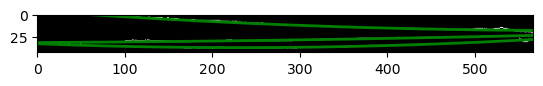

In [16]:
file_path = ".\\figure\\"
file_name = [str(f) for f in range(20,21)];
file_ext = ".png";
iterate_time = 6;
for f in file_name:
    print(file_path + f + file_ext + "\n");
    print("迭代次数: %d" %(iterate_time));
    catenary_fit(file_path,f,file_ext,iterate_time);